## Project Goal

The objective of this project is to **reproduce the results of the IVON paper**  
([Shen et al., 2024](https://proceedings.mlr.press/v235/shen24b.html)).  
IVON presents a refined and elegant synthesis of several influential prior works in adaptive Bayesian optimization and natural gradient methods, including:

- [**Khan et al.**](https://dl.acm.org/doi/abs/10.5555/3648699.3648980)  
- [**Khan & Rue**](https://proceedings.mlr.press/v80/khan18a.html)  
- [**Lin et al.**](https://proceedings.mlr.press/v119/lin20d.html)  
- [**Zhang et al.**](https://dl.acm.org/doi/10.5555/3454287.3454673)

This project aims to carefully reconstruct the experimental setup, methodology, and quantitative findings presented in the paper to ensure a faithful replication.

For deeper context, motivations, and additional explanations, consult:

- https://ysngshn.github.io/research/why-ivon/  
- https://adaptive-bayesian.ai/blog/ivon/
- https://github.com/team-approx-bayes/ivon-experiments


In [1]:
# !pip install torch --index-url https://download.pytorch.org/whl/cu118
!pip install ivon-opt


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import ivon
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
import sys
import torch

print("Python version:")
print(sys.version)

print("\nPyTorch version:")
print(torch.__version__)

# print("\nIs CUDA available?")
# print(torch.cuda.is_available())

# if torch.cuda.is_available():
#     print("CUDA version:")
#     print(torch.version.cuda)

#     print("\nGPU device name:")
#     print(torch.cuda.get_device_name(0))


Python version:
3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]

PyTorch version:
2.8.0+cu126


## Loading, Splitting, and Preparing the CIFAR-10 Dataset

This section loads the CIFAR-10 dataset and applies standard preprocessing used in many deep-learning experiments. CIFAR-10 contains 60,000 color images at 32×32 resolution across 10 classes. For more information, see the official dataset page: [CIFAR-10 Dataset](https://www.cs.toronto.edu/~kriz/cifar.html). We use the standard CIFAR-10 channel-wise mean and standard deviation `(0.4914, 0.4822, 0.4465)` and `(0.2470, 0.2435, 0.2616)` to normalize images, which helps stabilize training by making pixel values more consistent. The dataset is loaded using the `torchvision.datasets.CIFAR10` class documented at: [torchvision CIFAR10](https://docs.pytorch.org/vision/main/generated/torchvision.datasets.CIFAR10.html).

The code below first defines the normalization values, then creates two transform pipelines: a training transform that includes random cropping and horizontal flipping for data augmentation, and a testing transform that applies only tensor conversion and normalization. The training portion of the CIFAR-10 dataset is then loaded twice so we can construct a train/validation split: one version uses the augmented transforms for training, and the other uses the non-augmented transforms for validation. After splitting the dataset into training and validation subsets, we load the test set with only normalization. Finally, we wrap the train, validation, and test datasets in PyTorch `DataLoader` objects with a batch size of 50.

This procedure matches the dataset handling strategy used in the [IVON reference implementation](https://github.com/team-approx-bayes/ivon-experiments/blob/main/common/dataloaders.py).

In [4]:
# --- Standard CIFAR-10 normalization ---
mean = (0.4914, 0.4822, 0.4465)
std  = (0.2470, 0.2435, 0.2616)

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

# --- Load CIFAR-10 train data (will later be split into train and val) ---
full_train_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    transform=transform_train,   # training transform (with augmentation)
    download=True
)

# --- Create a validation dataset that uses NO augmentation ---
full_val_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    transform=transform_test,    # no augmentation for validation
    download=True
)

# --- Train/Val split ---
train_ratio = 0.9          # e.g., 90% train, 10% validation
n_train = int(len(full_train_dataset) * train_ratio)
n_val = len(full_train_dataset) - n_train

train_dataset, val_dataset = torch.utils.data.random_split(
    full_train_dataset,
    [n_train, n_val],
    generator=torch.Generator().manual_seed(42)   # reproducible split
)

# Replace validation transform
val_dataset.dataset = full_val_dataset

# --- Load CIFAR-10 test data ---
test_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    transform=transform_test,
    download=True
)

# --- DataLoaders (batch_size = 50 to match IVON paper) ---
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=50, shuffle=True)
val_loader   = torch.utils.data.DataLoader(val_dataset,   batch_size=50, shuffle=False)
test_loader  = torch.utils.data.DataLoader(test_dataset,  batch_size=50, shuffle=False)


100%|██████████| 170M/170M [00:14<00:00, 12.1MB/s]


### ResNet-20 Implementation

The following code block implements **ResNet-20 exactly as described in the original paper**  
[**Deep Residual Learning for Image Recognition**](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=7780459)

Important clarifications:

- The **original authors did not release their CIFAR-ResNet20 implementation in PyTorch**  
  (their official codebase was in [**Caffe**](https://github.com/KaimingHe/deep-residual-networks)).
- The **IVON paper** uses “the standard CIFAR-10 20-layer ResNet” from the original work,  
  but does **not** include its own ResNet20 implementation in the repository.
- Therefore, our implementation follows the **canonical and widely-used PyTorch version**:  
  https://github.com/kuangliu/pytorch-cifar/blob/master/models/resnet.py  
  which is a faithful reproduction of the architecture in the main ResNet paper.

This ensures that our model architecture is **fully aligned** with both the **original ResNet-20 design** and the **model used in IVON experiments**.


In [5]:

class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_planes, planes, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)

        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        return F.relu(out)

class ResNet20(nn.Module):
    def __init__(self):
        super().__init__()
        self.in_planes = 16

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)

        self.layer1 = self._make_layer(16, 3, stride=1)
        self.layer2 = self._make_layer(32, 3, stride=2)
        self.layer3 = self._make_layer(64, 3, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(64, 10)

    def _make_layer(self, planes, blocks, stride):
        strides = [stride] + [1]*(blocks-1)
        layers = []
        for s in strides:
            layers.append(BasicBlock(self.in_planes, planes, s))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        return self.fc(out)



The following cell provides helper functions to evaluate classification models — including both **deterministic optimizers** (e.g., SGD, AdamW) and **posterior-sampling optimizers** (e.g., IVON).  
The functions measure not only **accuracy** but also **uncertainty quality** through **calibration metrics** such as the **Expected Calibration Error (ECE)** and **Brier Score**.

Below, we detail each helper function and the mathematical definitions of the associated metrics.

---

## Helper Function Explanations

---

### 1. `evaluate_probs(model, optimizer, loader, device, test_samples)`
This helper evaluates a model on a dataloader and returns predicted class probabilities and labels.  
It supports both:
- **Standard optimizers** (SGD/AdamW)
- **Posterior-sampling optimizers** like **IVON**, which resample network weights.

#### What it does
- Sets the model to evaluation mode (`model.eval()`).
- Iterates over the dataloader without tracking gradients.
- Moves inputs/labels to the target device.
- **If using IVON ($T = \text{test_samples}$):**

  - If `test_samples == 1`:  
    Draws **one posterior sample** of the model parameters and computes softmax probabilities.
  - If `test_samples > 1`:  
    Performs **Monte Carlo averaging**:
    
$$
\bar{\mathbf{p}}_i = \frac{1}{T} \sum_{t=1}^{T} \operatorname{softmax}(f_{\theta_t}(\mathbf{x}_i))
$$


- **If using a regular optimizer:**  
  Uses the deterministic model weights directly.
- Concatenates all probabilities and labels from the dataset.

**Returns:**
- $\mathbf{P} \in \mathbb{R}^{N \times K}$: predicted probabilities  
- $\mathbf{y} \in \{1,\dots,K\}^N$: true labels

---

### 2. `plot_calibration_curve(probs, labels, n_bins=15, label_name="Model")`
Plots a **reliability diagram**, visualizing how predicted confidence aligns with empirical accuracy.

#### What it does
- Extracts:
  - $c_i = \max_k p_{ik}$: model confidence for sample $i$
  - $\hat{y}_i = \arg\max_k p_{ik}$: predicted class
- Defines correctness:

  $$
  \text{correct}_i =
  \begin{cases}
  1 & \text{if } \hat{y}_i = y_i \\
  0 & \text{otherwise}
  \end{cases}
  $$

- Bins samples by confidence $c_i$, and computes for each bin $B_m$:

  $$
  \text{acc}(B_m) = \frac{1}{|B_m|}\sum_{i \in B_m} \mathbf{1}[\hat{y}_i = y_i],
  \quad
  \text{conf}(B_m) = \frac{1}{|B_m|}\sum_{i \in B_m} c_i
  $$

- Plots points $(\text{conf}(B_m), \text{acc}(B_m))$ and the reference diagonal $y=x$.

This shows whether the model is **overconfident** (curve below diagonal) or **underconfident** (above diagonal).

---

### 3. `compute_ece(probs, labels, n_bins=15)`
Computes the **Expected Calibration Error (ECE)** — a scalar summary of calibration quality.

Let the confidence space $[0,1]$ be divided into $M$ bins $B_1, \dots, B_M$.  
Then:

$$
\boxed{
\text{ECE} = \sum_{m=1}^{M} \frac{|B_m|}{N} \, \big|\text{acc}(B_m) - \text{conf}(B_m)\big|
}
$$

A lower ECE indicates better calibration.

---

### 4. `evaluate_all_metrics(model, optimizer, loader, device, test_samples=1)`
Evaluates a model across **accuracy** and **uncertainty metrics** for both deterministic and stochastic optimizers.

#### Process
- Gathers probabilities $\mathbf{p}_i$ and true labels $y_i$.
- Computes the following metrics:

<table>
  <thead>
    <tr>
      <th style="text-align:left;">Metric</th>
      <th style="text-align:left;">Symbol</th>
      <th style="text-align:left; width: 60%;">Definition</th>
      <th style="text-align:center;">Direction</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td><b>Top-1 Accuracy</b></td>
      <td>$\text{Acc@1}$</td>
      <td>$$\displaystyle \frac{1}{N}\sum_i \mathbf{1}[\hat{y}_i = y_i]$$</td>
      <td align="center">↑</td>
    </tr>
    <tr>
      <td><b>Top-5 Accuracy</b></td>
      <td>$\text{Acc@5}$</td>
      <td>$$\displaystyle \frac{1}{N}\sum_i \mathbf{1}[y_i \in \text{Top5}(\mathbf{p}_i)]$$</td>
      <td align="center">↑</td>
    </tr>
    <tr>
      <td><b>Negative Log-Likelihood</b></td>
      <td>$\text{NLL}$</td>
      <td>$$\displaystyle -\frac{1}{N}\sum_i \log p_{i, y_i}$$</td>
      <td align="center">↓</td>
    </tr>
    <tr>
      <td><b>Expected Calibration Error</b></td>
      <td>$\text{ECE}$</td>
      <td>$$\displaystyle \sum_m \frac{|B_m|}{N} \, \big|\text{acc}(B_m)-\text{conf}(B_m)\big|$$</td>
      <td align="center">↓</td>
    </tr>
    <tr>
      <td><b>Brier Score</b></td>
      <td>$\text{Brier}$</td>
      <td>$$\displaystyle \frac{1}{N}\sum_i\sum_k (p_{ik} - \mathbf{1}[y_i=k])^2$$</td>
      <td align="center">↓</td>
    </tr>
  </tbody>
</table>

#### Intuition
- **Top-1/Top-5 Accuracy:** correctness of predictions.  
- **NLL:** penalizes incorrect or low-confidence correct predictions.  
- **ECE:** measures alignment of predicted confidence with observed accuracy.  
- **Brier Score:** mean squared deviation of predicted probabilities from one-hot truth.

**Returns:**
A dictionary with all metrics and raw predictions (`probs`, `labels`).

---

### 5. `compare_methods(methods_dict, loader, device)`
Evaluates multiple optimization methods under a unified evaluation protocol.

#### Input Format
```python
methods_dict = {
    "SGD":       (model_sgd, optimizer_sgd, 1),
    "AdamW":     (model_adamw, optimizer_adamw, 1),
    "IVON@mean": (model_ivon_mean, optimizer_ivon, 1),
    "IVON-MC8":  (model_ivon, optimizer_ivon, 8)
}


In [6]:
def evaluate_probs(model, optimizer, loader, device, test_samples=1):
    model.eval()
    all_probs, all_labels = [], []

    with torch.no_grad():
        for X, y in loader:
            X = X.to(device)
            y = y.to(device)

            # ---- IVON case ----
            if hasattr(optimizer, "sampled_params"):
                if test_samples == 1:
                    # one posterior sample
                    with optimizer.sampled_params(train=False):
                        logits = model(X)
                        probs = F.softmax(logits, dim=1)
                else:
                    # multi-sample Monte Carlo averaging
                    sampled_probs = []
                    for _ in range(test_samples):
                        with optimizer.sampled_params(train=False):
                            logits = model(X)
                            sampled_probs.append(F.softmax(logits, dim=1))

                    probs = torch.mean(torch.stack(sampled_probs, dim=0), dim=0)

            # ---- SGD/AdamW case ----
            else:
                logits = model(X)
                probs = F.softmax(logits, dim=1)

            all_probs.append(probs.detach().cpu())
            all_labels.append(y.detach().cpu())

    return torch.cat(all_probs), torch.cat(all_labels)


def plot_calibration_curve(probs, labels, n_bins=15, label_name="Model"):
    confidences, predictions = probs.max(1)
    correctness = predictions.eq(labels)

    frac_pos, mean_conf = calibration_curve(
        correctness.int().numpy(),
        confidences.numpy(),
        n_bins=n_bins
    )

    plt.plot(mean_conf, frac_pos, marker="o", label=label_name)
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.xlabel("Mean predicted confidence")
    plt.ylabel("Fraction of correct predictions")
    plt.title("Calibration Curve (Reliability Diagram)")
    plt.legend()
    plt.grid(True)




# ---------- ECE implementation (equal-width bins) ----------
def compute_ece(probs, labels, n_bins=15):
    confidences, predictions = probs.max(1)
    correctness = predictions.eq(labels)

    ece = 0.0
    bin_boundaries = torch.linspace(0, 1, n_bins + 1)

    for i in range(n_bins):
        low, high = bin_boundaries[i], bin_boundaries[i+1]
        mask = (confidences > low) & (confidences <= high)

        if mask.sum() == 0:
            continue

        bin_conf = confidences[mask].mean()
        bin_acc = correctness[mask].float().mean()
        ece += (mask.float().mean() * (bin_conf - bin_acc).abs())

    return ece.item()


# ---------- Main evaluation helper ----------
def evaluate_all_metrics(model, optimizer, loader, device, test_samples=1):
    model.eval()
    all_probs, all_labels = [], []

    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device), y.to(device)

            # --- IVON case: sample parameters ---
            if hasattr(optimizer, "sampled_params"):
                if test_samples == 1:
                    with optimizer.sampled_params(train=False):
                        logits = model(X)
                        probs = F.softmax(logits, dim=1)
                else:
                    mc_probs = []
                    for _ in range(test_samples):
                        with optimizer.sampled_params(train=False):
                            logits = model(X)
                            mc_probs.append(F.softmax(logits, dim=1))
                    probs = torch.mean(torch.stack(mc_probs, dim=0), dim=0)

            # --- SGD/AdamW case ---
            else:
                logits = model(X)
                probs = F.softmax(logits, dim=1)

            all_probs.append(probs.cpu())
            all_labels.append(y.cpu())

    probs = torch.cat(all_probs)
    labels = torch.cat(all_labels)

    # ---------- Metrics ----------
    # Top-1 accuracy
    top1 = (probs.argmax(1) == labels).float().mean().item()

    # Top-5 accuracy (CIFAR-10 has 10 classes → safe)
    top5 = (
        probs.topk(5, dim=1).indices.eq(labels.unsqueeze(1))
        .any(dim=1)
        .float()
        .mean()
        .item()
    )

    # Negative Log-Likelihood
    nll = F.nll_loss(probs.log(), labels, reduction="mean").item()

    # Expected Calibration Error
    ece = compute_ece(probs, labels)

    # Brier score
    one_hot = F.one_hot(labels, num_classes=probs.size(1)).float()
    brier = ((probs - one_hot) ** 2).mean().item()

    return {
        "Top-1 Acc ↑": top1,
        "Top-5 Acc ↑": top5,
        "NLL ↓": nll,
        "ECE ↓": ece,
        "Brier ↓": brier,
        "probs": probs,
        "labels": labels,
    }
# metrics = evaluate_all_metrics(
#     model=model,
#     optimizer=optimizer,     # SGD, AdamW, IVON, etc.
#     loader=test_loader,
#     device=device,
#     test_samples=10          # for IVON MC-averaging
# )




def compare_methods(methods_dict, loader, device):
    """
    methods_dict = {
        "SGD":        (model_sgd, optimizer_sgd, 1),
        "AdamW":      (model_adamw, optimizer_adamw, 1),
        "IVON@mean":  (model_ivon_mean, optimizer_ivon, 1),
        "IVON-MC3":   (model_ivon, optimizer_ivon, 3),
        "IVON-MC8":   (model_ivon, optimizer_ivon, 8)
    }
    """

    results = []

    for name, (model, optimizer, test_samples) in methods_dict.items():
        print(f"Evaluating {name} (test_samples={test_samples}) ...")

        metrics = evaluate_all_metrics(
            model=model,
            optimizer=optimizer,
            loader=loader,
            device=device,
            test_samples=test_samples
        )

        results.append({
            "Method": name,
            "Top-1 Acc ↑": metrics["Top-1 Acc ↑"],
            "Top-5 Acc ↑": metrics["Top-5 Acc ↑"],
            "NLL ↓": metrics["NLL ↓"],
            "ECE ↓": metrics["ECE ↓"],
            "Brier ↓": metrics["Brier ↓"]
        })

    df = pd.DataFrame(results)
    df = df.set_index("Method")

    print("\n=== Comparison Table ===")
    print(df)

    return df


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# --- Train IVON ---
model_ivon = ResNet20().to(device)

optimizer_ivon = ivon.IVON(model_ivon.parameters(), lr=0.1, ess=len(train_dataset))

train_samples = 1

for epoch in range(10):
    model_ivon.train()
    for X, y in train_loader:
        X, y = X.to(device), y.to(device)

        optimizer_ivon.zero_grad()

        for _ in range(train_samples):
            with optimizer_ivon.sampled_params(train=True):
                logits = model_ivon(X)
                loss = F.cross_entropy(logits, y)
                loss.backward()

        optimizer_ivon.step()

    print(f"IVON Epoch done: {epoch+1}")


# optimizer = ivon.IVON(
#     model.parameters(),
#     lr=0.2,                     # α in the paper
#     ess=len(train_dataset),     # 50,000 for CIFAR-10
#     hess_init=0.05,             # h0 from the paper
#     beta1=0.9,                  # β1
#     beta2=1 - 1e-5,             # β2
#     weight_decay=5e-5           # δ from the paper
# )


IVON Epoch done: 1
IVON Epoch done: 2
IVON Epoch done: 3
IVON Epoch done: 4
IVON Epoch done: 5
IVON Epoch done: 6
IVON Epoch done: 7
IVON Epoch done: 8
IVON Epoch done: 9
IVON Epoch done: 10


In [ ]:
def train_sgd(model, optimizer, train_loader, device, epochs=10):
    model.to(device)

    for epoch in range(epochs):
        model.train()
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)

            optimizer.zero_grad()
            logits = model(X)
            loss = F.cross_entropy(logits, y)
            loss.backward()
            optimizer.step()

        print(f"SGD Epoch done: {epoch+1}")


model_sgd = ResNet20().to(device)
optimizer_sgd = torch.optim.SGD(model_sgd.parameters(), lr=0.1)


train_sgd(model_sgd, optimizer_sgd, train_loader, device=device, epochs=10)


SGD Epoch done: 1
SGD Epoch done: 2
SGD Epoch done: 3
SGD Epoch done: 4
SGD Epoch done: 5
SGD Epoch done: 6
SGD Epoch done: 7
SGD Epoch done: 8
SGD Epoch done: 9
SGD Epoch done: 10


In [ ]:
def train_adam(model, optimizer, train_loader, device, epochs=10):
    model.to(device)

    for epoch in range(epochs):
        model.train()  # MUST be inside the loop

        for X, y in train_loader:
            X, y = X.to(device), y.to(device)

            optimizer.zero_grad()
            logits = model(X)
            loss = F.cross_entropy(logits, y)
            loss.backward()
            optimizer.step()

        print(f"Adam Epoch {epoch+1} done")


model_adam = ResNet20().to(device)
# optimizer_adam = torch.optim.Adam(model_adam.parameters(), lr=0.001)

optimizer_adam = torch.optim.AdamW(
    model_adam.parameters(),
    lr=1e-3,
    weight_decay=5e-4,
    betas=(0.9, 0.999)
)


train_adam(model_adam, optimizer_adam, train_loader, device, epochs=10)


Adam Epoch 1 done
Adam Epoch 2 done
Adam Epoch 3 done
Adam Epoch 4 done
Adam Epoch 5 done
Adam Epoch 6 done
Adam Epoch 7 done
Adam Epoch 8 done
Adam Epoch 9 done
Adam Epoch 10 done



Running unified evaluation...

Evaluating SGD (test_samples=1) ...
Evaluating Adam (test_samples=1) ...
Evaluating IVON@mean (test_samples=1) ...
Evaluating IVON-MC5 (test_samples=5) ...

=== Comparison Table ===
           Top-1 Acc ↑  Top-5 Acc ↑     NLL ↓     ECE ↓   Brier ↓
Method                                                           
SGD             0.8155       0.9906  0.556858  0.044931  0.026645
Adam            0.8111       0.9907  0.560757  0.033737  0.026968
IVON@mean       0.8117       0.9908  0.558807  0.035641  0.026836
IVON-MC5        0.8139       0.9917  0.543080  0.030029  0.026318
Plotting calibration curve for SGD ...
Plotting calibration curve for Adam ...
Plotting calibration curve for IVON@mean ...
Plotting calibration curve for IVON-MC5 ...


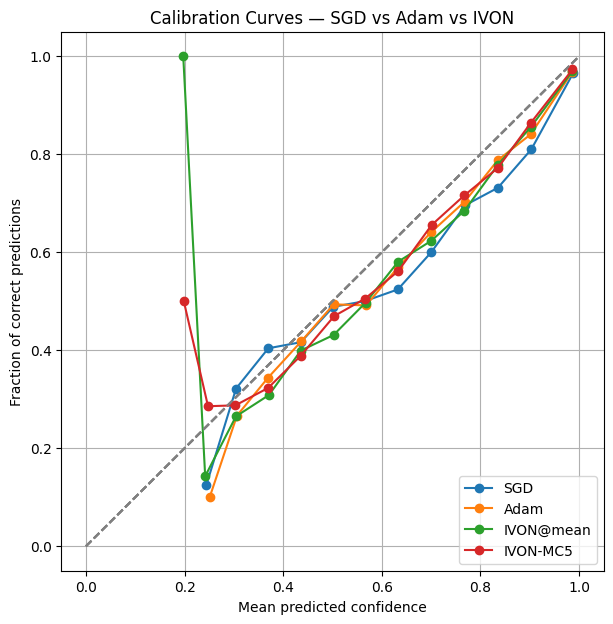


Final Comparison Table:


,Top-1 Acc ↑,Top-5 Acc ↑,NLL ↓,ECE ↓,Brier ↓
Method,,,,,
SGD,0.8155,0.9906,0.556858,0.044931,0.026645
Adam,0.8111,0.9907,0.560757,0.033737,0.026968
IVON@mean,0.8117,0.9908,0.558807,0.035641,0.026836
IVON-MC5,0.8139,0.9917,0.543080,0.030029,0.026318


In [ ]:
# --- Unified evaluation: SGD vs Adam vs IVON@mean vs IVON posterior-average ---

print("\nRunning unified evaluation...\n")

methods = {
    "SGD":        (model_sgd,  optimizer_sgd,      1),
    "Adam":       (model_adam, optimizer_adam,     1),
    "IVON@mean":  (model_ivon, optimizer_ivon,     1),
    "IVON-MC5":   (model_ivon, optimizer_ivon,     5),
}


df_results = compare_methods(methods, test_loader, device)

# --- Plot calibration curves ---
plt.figure(figsize=(7,7))

for name, (model_m, optim_m, test_samples) in methods.items():
    print(f"Plotting calibration curve for {name} ...")
    probs, labels = evaluate_probs(model_m, optim_m, test_loader, device, test_samples)
    plot_calibration_curve(probs, labels, n_bins=15, label_name=name)

plt.title("Calibration Curves — SGD vs Adam vs IVON")
plt.legend()
plt.grid(True)
plt.show()

# --- Show results table again clearly ---
print("\nFinal Comparison Table:")
display(df_results)


## Understanding `train_samples` and `test_samples` in IVON

Having understood the implementation details in the previous cells of the notebook, we now turn to clarify the conceptual distinction between the two sampling parameters, **`train_samples`** and **`test_samples`**, which appear in the code. Both originate from the same variational Bayesian principle but play distinct roles in the learning and inference stages. During training, the optimizer minimizes

$$
{L}(q) = \lambda\, \mathbb{E}_{q_{\eta}(\theta)}[\bar{\ell}(\theta)] + D_{\mathrm{KL}}(q_{\eta}(\theta)\,\|\,p(\theta)),
$$  

where $q_{\eta}(\theta)$ is the approximate posterior over network weights. Because the expectation over $q_{\eta}(\theta)$ is intractable, it is replaced by a Monte Carlo estimate obtained through a finite number of **train-time samples**:  

$$
\nabla_{\eta}{L}(q) \approx \frac{1}{S_{\text{train}}} \sum_{s=1}^{S_{\text{train}}} \nabla_{\eta}\ell(\theta^{(s)}),
\quad \theta^{(s)} \sim q_{\eta}(\theta).
$$  

Each sampled parameter vector $\theta^{(s)}$ represents a stochastic realization of the model’s weights used to compute the loss gradient, thereby injecting uncertainty directly into the optimization process. The parameter `train_samples` thus determines how many such draws are taken per minibatch, balancing computational cost against the variance of the gradient estimate.

At evaluation time, the same variational posterior $q_{\eta}(\theta)$ is employed to form predictions that integrate over parameter uncertainty. Since the predictive distribution  

$$
p(y \mid x) = \int p(y \mid x, \theta)\, q_{\eta}(\theta)\, d\theta
$$  

is also analytically intractable, it is approximated via Monte Carlo averaging over **test-time samples**:  

$$
p(y \mid x) \approx \frac{1}{S_{\text{test}}} \sum_{s=1}^{S_{\text{test}}} p(y \mid x, \theta^{(s)}),
\quad \theta^{(s)} \sim q_{\eta}(\theta).
$$  

Here, `test_samples` specifies the number of posterior weight realizations used to average predictions, determining the accuracy of the Bayesian model average approximation. Increasing `test_samples` improves calibration and negative log-likelihood but incurs greater inference cost. As demonstrated in the subsequent code reproducing **Figure 4** of the original paper, varying these two sampling parameters—during both training and testing—reveals their complementary influence on model accuracy and uncertainty, illustrating how IVON leverages stochasticity across both phases to achieve well-calibrated predictive performance.


test_samples=1 → Acc=0.8008, NLL=0.5911
test_samples=2 → Acc=0.8039, NLL=0.5833
test_samples=4 → Acc=0.8036, NLL=0.5787
test_samples=8 → Acc=0.8062, NLL=0.5767
test_samples=16 → Acc=0.8055, NLL=0.5752
train_samples=1 → Acc=0.7971, NLL=0.6064
train_samples=2 → Acc=0.8294, NLL=0.4998
train_samples=4 → Acc=0.8190, NLL=0.5448
train_samples=8 → Acc=0.8191, NLL=0.5439
train_samples=16 → Acc=0.7984, NLL=0.6074


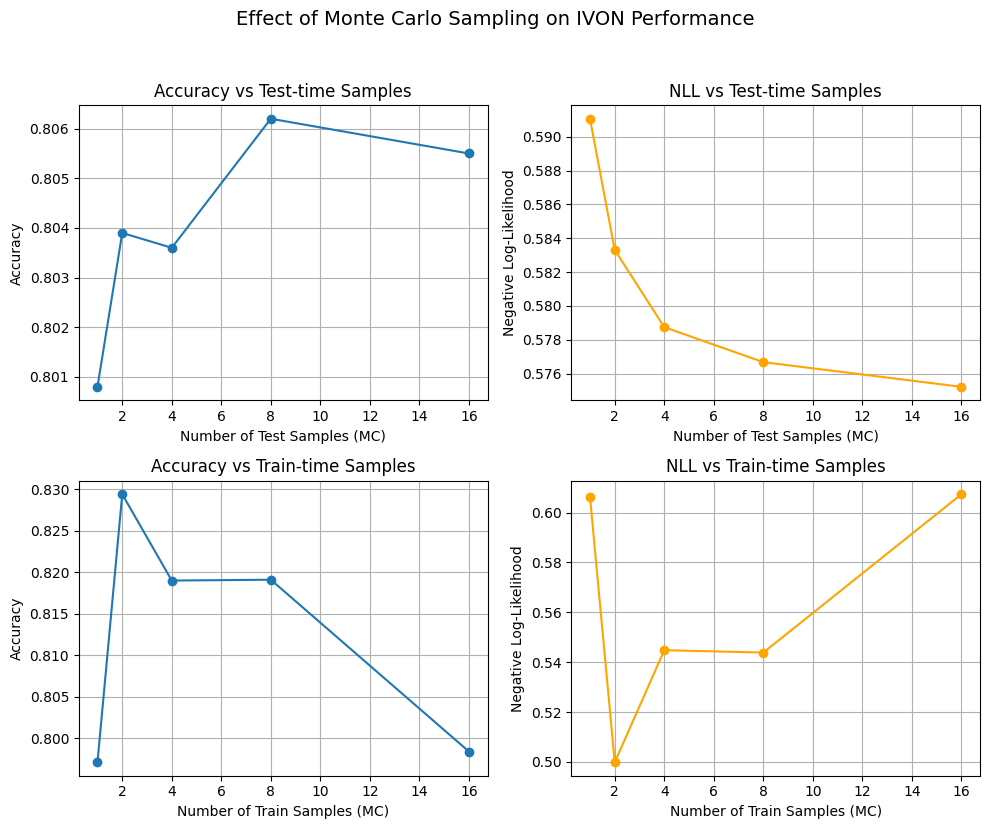

In [7]:
# ==============================================================
# Reproduce Figure 4 from the IVON paper:
# Effect of Monte Carlo samples during inference (top row)
# and training (bottom row) on Accuracy and NLL.
# ==============================================================

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# --------------------------------------------------------------
# 1. Train IVON with different train_samples values
# --------------------------------------------------------------
def train_ivon(train_samples=1, epochs=10):
    model = ResNet20().to(device)
    optimizer = ivon.IVON(model.parameters(), lr=0.1, ess=len(train_dataset))

    for epoch in range(epochs):
        model.train()
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            for _ in range(train_samples):
                with optimizer.sampled_params(train=True):
                    logits = model(X)
                    loss = F.cross_entropy(logits, y)
                    loss.backward()
            optimizer.step()
    return model, optimizer


# --------------------------------------------------------------
# 2. Evaluate Accuracy and NLL for different test_samples values
# --------------------------------------------------------------

def evaluate_metric_sweep(model, optimizer, test_loader, test_samples_list):
    accs, nlls = [], []
    for t in test_samples_list:
        metrics = evaluate_all_metrics(model, optimizer, test_loader, device, test_samples=t)
        accs.append(metrics["Top-1 Acc ↑"])
        nlls.append(metrics["NLL ↓"])
        print(f"test_samples={t} → Acc={accs[-1]:.4f}, NLL={nlls[-1]:.4f}")
    return accs, nlls


# --------------------------------------------------------------
# 3. Figure 4 — Top row: Varying test_samples
# --------------------------------------------------------------

# Train once with train_samples = 1 (as in paper)
model_test_sweep, optimizer_test_sweep = train_ivon(train_samples=1, epochs=10)

test_samples_list = [1, 2, 4, 8, 16]
accs_test, nlls_test = evaluate_metric_sweep(model_test_sweep, optimizer_test_sweep, test_loader, test_samples_list)

# --------------------------------------------------------------
# 4. Figure 4 — Bottom row: Varying train_samples
# --------------------------------------------------------------

train_samples_list = [1, 2, 4, 8, 16]
accs_train, nlls_train = [], []

for s in train_samples_list:
    model_s, opt_s = train_ivon(train_samples=s, epochs=10)
    metrics = evaluate_all_metrics(model_s, opt_s, test_loader, device, test_samples=1)
    accs_train.append(metrics["Top-1 Acc ↑"])
    nlls_train.append(metrics["NLL ↓"])
    print(f"train_samples={s} → Acc={accs_train[-1]:.4f}, NLL={nlls_train[-1]:.4f}")


# --------------------------------------------------------------
# 5. Plotting (2x2 grid)
# --------------------------------------------------------------

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
plt.subplots_adjust(hspace=0.3, wspace=0.3)

# --- Top row: varying test_samples ---
axes[0, 0].plot(test_samples_list, accs_test, marker="o", label="Accuracy")
axes[0, 0].set_title("Accuracy vs Test-time Samples")
axes[0, 0].set_xlabel("Number of Test Samples (MC)")
axes[0, 0].set_ylabel("Accuracy")
axes[0, 0].grid(True)

axes[0, 1].plot(test_samples_list, nlls_test, marker="o", color="orange", label="NLL")
axes[0, 1].set_title("NLL vs Test-time Samples")
axes[0, 1].set_xlabel("Number of Test Samples (MC)")
axes[0, 1].set_ylabel("Negative Log-Likelihood")
axes[0, 1].grid(True)

# --- Bottom row: varying train_samples ---
axes[1, 0].plot(train_samples_list, accs_train, marker="o", label="Accuracy")
axes[1, 0].set_title("Accuracy vs Train-time Samples")
axes[1, 0].set_xlabel("Number of Train Samples (MC)")
axes[1, 0].set_ylabel("Accuracy")
axes[1, 0].grid(True)

axes[1, 1].plot(train_samples_list, nlls_train, marker="o", color="orange", label="NLL")
axes[1, 1].set_title("NLL vs Train-time Samples")
axes[1, 1].set_xlabel("Number of Train Samples (MC)")
axes[1, 1].set_ylabel("Negative Log-Likelihood")
axes[1, 1].grid(True)

plt.suptitle("Effect of Monte Carlo Sampling on IVON Performance", fontsize=14, y=1.03)
plt.tight_layout()
plt.show()
